## Install Prerequisites


In [51]:
!pip install gym
!pip install numpy

In [52]:
import sys
import numpy as np
import pandas as pd
import gym
import os
from gym import spaces
from collections import OrderedDict, namedtuple
from pathlib import Path
from dataclasses import dataclass
from typing import Tuple, Union, List, Dict
import matplotlib.pyplot as plt
from datenano import datetime
import math


In [53]:
# set up plyplot
plt.style.use('dark_background')
%matplotlib inline

In [54]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from indicators import (indicators, normalize)

In [55]:
FILES = [Path(os.getcwd()) / "../data/xtbusd_1h_2019.csv"]
COLUMNS = ["idx",
           "Time",
           "Period",
           "Open",
           "High",
           "Low",
           "Close",
           "PriceAverage",
           "TradeAverage",
           "SellAverage",
           "BuyAverage",
           "TradeMedian",
           "Volume",
           "TradeCount"]
INIT_ACCOUNT_BALANCE = 10_000
MAX_ACCOUNT_BALANCE = 1_000_0000
MAX_NUMBER_SHARES = 1000
MAX_PER_COST = 100_000
FEE_MIN = 20
FEE_MAX = 50
REWARD_SCALING = 1e-4
LEARNING_RATE = 1e-3
GAMMA = 0.99
MAX_STEPS = 100

In [56]:
INDICATOR_PADDING = 50

INDICATORS: Dict[str, indicators.Set] = {
    "Close": indicators.Set([
        indicators.SMA(12),
        # indicators.SMA(24),
        indicators.SMA(50),
        indicators.EMA(12),
        # indicators.EMA(24),
        indicators.EMA(50),
        indicators.BBANDS(16,2),
        indicators.BBANDS(16,3),
    ]),
    "BuySellDiff": indicators.Set([
        indicators.SMA(12),
        # indicators.SMA(24),
        indicators.SMA(50),
        indicators.EMA(12),
        # indicators.EMA(24),
        indicators.EMA(50),
    ], prepend="BuySellDiff"),
    "VolumeEma": indicators.Set([
        indicators.EMA(12),
        # indicators.EMA(24),
        indicators.EMA(50),
    ], prepend="Volume"),
    "ATR": indicators.Set([
        indicators.ATR(14),
    ]),
    "KelBbandDif": indicators.Set([
        indicators.KelBbandDif(),
    ]),
    "RSI": indicators.Set([
        indicators.RSI(10),
        indicators.RSI(20),
    ])
}

In [57]:

class DataFile:

    def __init__(self, file: str, skip_rows: int, columns: List[str], dtype = np.float32):
        self.file = file
        self.skip_rows = skip_rows
        self.columns = columns
        self.data: Union[np.ndarray,None] = None
        self.prices: Union[np.array,None] = None
        self.dtype = dtype
        self.times: Union[pd.Series,None] = None
        self.__shape: Tuple[int, int] = (0,0)
        self._len = 0

    def load(self) -> np.ndarray:
        """ loads data from the file into memory and applies our transformations """
        if self.data is not None:
            # already loaded
            return self.data

        df = pd.read_csv(self.file,
                         header=None,
                         names=self.columns,
                         skiprows=self.skip_rows,
                         dtype=self.dtype)

        column_sets = []

        # apply all indicator sets
        df = INDICATORS["Close"].concat(df, df["Close"])
        column_sets.append(["Close", "Open", "High", "Low", "PriceAverage"] + INDICATORS["Close"].output_names())

        # RSIs
        df = INDICATORS["RSI"].concat(df, df["Close"])
        column_sets.append(INDICATORS["RSI"].output_names())

        # Kelter channel bband diff
        df = INDICATORS["KelBbandDif"].concat(df, df["High"], df["Low"], df["Close"])
        column_sets.append(INDICATORS["KelBbandDif"].output_names())

        # Volume moving averages
        df = INDICATORS["VolumeEma"].concat(df, df["Volume"])
        column_sets.append(INDICATORS["VolumeEma"].output_names() + ["Volume"])

        # get the diff between the buy average and the sell average
        df["BuySellDiff"] = df["BuyAverage"] - df["SellAverage"]
        df = INDICATORS["BuySellDiff"].concat(df, df["BuySellDiff"])
        column_sets.append(INDICATORS["BuySellDiff"].output_names() + ["BuySellDiff"])

        # drop all rows with empty values
        df = df.dropna()

        fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
        ax1.plot(df["Close"])
        ax1.set(ylabel="$", title="Bitcoin Value")
        ax2.plot(df["Volume"])
        ax2.set(ylabel="Volume", title="Bitcoin Volume")
        plt.show()

        self.prices = df["Close"].to_numpy(dtype=self.dtype)
        self.times = []
        for t in df["Time"].to_numpy():
            time_int = int(t)
            self.times.append(datetime.from_ns(time_int).strftime('%Y-%m-%d %H:%M:%S'))

        # print(self.times)

        # get the first normalized frame
        tdf = normalize.min_max_dataframe(df[column_sets.pop(0)])

        # loop over the rest of the column sets and concat the resulting frames
        for cols in column_sets:
            tdf = pd.concat((tdf, normalize.min_max_dataframe(df[cols])), axis=1, join="outer")

        # store the data as a numpy array
        self.data = tdf.to_numpy(dtype=self.dtype)
        self._len = len(self.data)
        # set the shape of the data
        self.__shape = self.data.shape

        print(f"loaded {self._len} rows of data from {self.file}")
        return self.data

    @property
    def shape(self):
        return self.__shape

    def unload(self):
        """ unloads the data from memory """
        print(f"unloaded data from {self.file}")
        self.data = None
        self.times = None
        self.prices = None

    def sample(self, idx: int, window: int) -> np.ndarray:
        """ sample returns a sample from the data set """
        if self.data is None:
            self.load()
        return self.data[idx:idx+window]

    def price_at(self, idx: int):
        """ sample returns a sample from the data set """
        if self.data is None:
            self.load()
        return self.prices[idx]

    def time_at(self, idx: int):
        """ sample returns a sample from the data set """
        if self.data is None:
            self.load()
        return self.times[idx]

    def __len__(self):
        return self._len

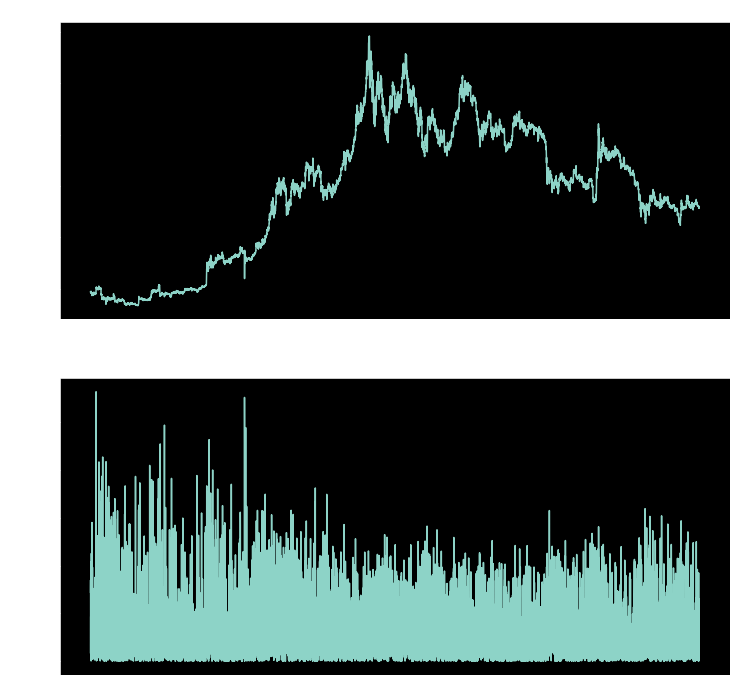

loaded 15101 rows of data from /Users/eric/Projects/cryptonomicon/notebooks/../data/xtbusd_1h_2019_clean.csv
[0.05918757 0.05395415 0.05967897 0.05362655 0.05645637 0.05436093
 0.05024981 0.05483211 0.05024981 0.05786485 0.05372842 0.04959198
 0.05993307 0.05372842 0.04752377 0.6405923  0.5748788  0.26872736
 0.2784348  0.15376753 0.13799404 0.25650382 0.5090897  0.50761294
 0.5108637  0.50761294 0.53208196]


In [58]:
data_file = DataFile(
    file=FILES[0],
    columns=COLUMNS,
    skip_rows=1
)

data_file.load()
print(data_file.sample(0,1)[0])


In [59]:
@dataclass
class DataSlice:
    file_idx: int
    idx: int


class CryptoCandles(gym.Env):
    """crypto candles environment"""
    
    def __init__(self, csv_files: list, window: int):
        super(CryptoCandles, self).__init__()
        assert window >= 5, "window size must be 5 or greater"
        self.window = window
        self.files = OrderedDict()
        self.slice_map = OrderedDict()

        slice_idx = 0
        self.cols = 0

        for i in range(len(csv_files)):

            self.files[i] = DataFile(
                file=csv_files[i],
                skip_rows=1,
                columns=COLUMNS,
            )

            # load the data file
            self.files[i].load()

            data_len = len(self.files[i])

            if self.cols != 0:
                assert(self.files[i].shape[1] == self.cols), "number of columns in all files must match"
            else:
                self.cols = self.files[i].shape[1]

            # add slices for
            for j in range(data_len):
                if j + self.window > data_len:
                    # cannot add any more
                    break
                self.slice_map[slice_idx] = DataSlice(
                    file_idx=i,
                    idx=j,
                )
                slice_idx += 1

        self._len = len(self.slice_map)

        assert(self._len > 0), "length of chart slices from loaded from the csv file(s) must be greater than 1"

        # action space is discrete, we'll either buy 100%, sell 100% or hold
        self.action_space = spaces.Discrete(3)
        # observation space will contain last *window*

        self.observation_space = spaces.Box(low=0, high=1, shape=(self.window*self.cols+6,), dtype=np.float32)

        # values that will be reset
        self.balance = INIT_ACCOUNT_BALANCE
        self.net_worth = INIT_ACCOUNT_BALANCE
        self.max_net_worth = INIT_ACCOUNT_BALANCE
        self.amount_held = 0.
        self.cost_basis = 0.
        self.total_sold = 0.
        self.total_sales_value = 0.
        self.current_step = 0
        self.balance_history = [INIT_ACCOUNT_BALANCE]
        self.net_worth_history = [INIT_ACCOUNT_BALANCE]
        self.action_history = []
        self.reward = 0
        self.reward_history = []
        self.trade_count = 0
        self.terminal = False
        self.state = None
        self.steps_without_trade = 0

    def _idx(self, idx=0) -> Tuple[int, int]:
        assert idx <= self._len, f"index {idx} out of range"
        return self.slice_map[idx].file_idx, self.slice_map[idx].idx

    def _sample(self, idx=0) -> np.ndarray:
        f, s = self._idx(idx)
        return self.files[f].sample(s, self.window).flatten()

    def _price_at(self, idx=0) -> np.float:
        f, s = self._idx(idx)
        return self.files[f].price_at(s)

    def _time_at(self, idx=0) -> str:
        f, s = self._idx(idx)
        return self.files[f].time_at(s)

    def get_state(self) -> np.ndarray:
        """ get the current step's observation """
        sample = self._sample(self.current_step)
        addition_data = [
            min(self.balance / MAX_ACCOUNT_BALANCE, 1),
            min(self.max_net_worth / MAX_ACCOUNT_BALANCE, 1),
            min(self.amount_held / MAX_NUMBER_SHARES, 1),
            min(self.cost_basis / MAX_PER_COST, 1),
            min(self.total_sold / MAX_NUMBER_SHARES, 1),
            min(self.total_sales_value / (MAX_NUMBER_SHARES * MAX_PER_COST), 1),
        ]

        for x in addition_data:
            sample = np.append(sample, x)

        return sample

    def _sell(self) -> bool:
        current_price = self._price_at(self.current_step)
        """ sell the stock """
        if self.amount_held == 0:
            # cannot sell 0
            return False

        # print(f"{self._time_at(self.current_step)}: selling {self.amount_held} at current price of ${current_price} per")
        self.total_sold += self.amount_held
        self.balance += self.amount_held * current_price - self._get_fee()
        self.total_sales_value += self.amount_held * current_price
        self.amount_held = 0
        self.cost_basis = 0
        self.trade_count += 1
        return True

    @staticmethod
    def _get_fee():
        return random.randint(FEE_MIN,FEE_MAX)

    def _buy(self) -> bool:
        round_to = 0.00001
        current_price = self._price_at(self.current_step)
        # we're buying
        if self.amount_held > 0:
            # cannot buy while holding any
            return False

        buy_amount = int(((self.balance - self._get_fee()) / current_price) / round_to) * round_to
        # print(f"{self._time_at(self.current_step)}: buying {buy_amount} at current price of ${current_price} per")
        self.balance -= buy_amount * current_price
        self.amount_held = buy_amount
        self.cost_basis = current_price
        self.trade_count += 1
        self.steps_without_position = 0
        return True

    def take_action(self, action: int) -> bool:
        """
        take action
        0 = hold
        1 = buy
        2 = sell
        """

        took_action = False
        if action < 1:
            # nothing changes, we're holding
            took_action = False
        elif action < 2:
            # if self.steps_without_trade > 1:
            took_action = self._buy()
        else:
            took_action  = self._sell()

        self.net_worth = self._price_at(self.current_step) * self.amount_held + self.balance
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        return took_action

    def step(self, action: int):
        prev_net_worth = self.net_worth
        # current_price = self._price_at(self.current_step)
        took_action = self.take_action(action)
        # self.take_action(action)

        self.current_step += 1

        if self.current_step >= self._len:
            self.terminal = True
            self.current_step = 0

        self.state = self.get_state()

        if self.net_worth == prev_net_worth:
            self.reward = 0
        else:
            # reward is the percentage diff between last and prev net worth
            self.reward = self.net_worth - prev_net_worth

        # self.reward = self.net_worth - prev_net_worth

        # adjust award based on price direction if we chose to do nothing
        # todo: keep track of potential
        if not took_action:
            self.steps_without_trade += 1
        #     if self.current_step > 1 and self.amount_held > 0:
        #             # opportunity cost of not selling
        #             round_to = 0.00001
        #             opportunity_cost = -((buy_amount_prev * current_price) - (buy_amount_prev * prev_price))
        #             self.reward = opportunity_cost / self.net_worth


                # self.reward -= (buy_amount_prev * current_price) - (buy_amount_prev * prev_price)
                # print(f"opportunity cost = ${self.reward} ... prev price = ${prev_price}, current_price = ${current_price}")
            # self.reward -= math.pow(self.steps_without_trade, 2) / 1000
        else:
            self.steps_without_trade = 0

        self.reward *= REWARD_SCALING
        self.reward_history.append(self.reward)
        self.action_history.append(action)

        if self.net_worth <= 1000:
            # we're fucked
            self.terminal = True

        self.balance_history.append(self.balance)
        self.net_worth_history.append(self.net_worth)

        if self.terminal:
            fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(24,24))
            ax1.plot(self.net_worth_history)
            ax1.set(ylabel="Net Worth", title="Net Worth History")
            ax2.scatter(list(range(0,len(self.reward_history))), self.reward_history, s=2)
            ax2.set(ylabel="Reward", title="Reward History")
            ax3.scatter(list(range(0,len(self.action_history))), self.action_history, s=2)
            ax3.set(ylabel="Action", title="Action History")
            plt.show()

        return self.state, self.reward, self.terminal, {}

    
    def reset(self):
        # values that will be reset
        self.balance = INIT_ACCOUNT_BALANCE
        self.net_worth = INIT_ACCOUNT_BALANCE
        self.max_net_worth = INIT_ACCOUNT_BALANCE
        self.balance_history = [INIT_ACCOUNT_BALANCE]
        self.net_worth_history = [INIT_ACCOUNT_BALANCE]
        self.amount_held = 0.
        self.cost_basis = 0.
        self.total_sold = 0.
        self.total_sales_value = 0.
        self.current_step = 0
        self.reward_history = []
        self.action_history = []
        self.trade_count = 0
        self.terminal = False
        self.steps_without_trade = 0

        return self.get_state()

    def render(self, mode='human'):
        print(f"------------------------------\n"
              f"STEP # {self.current_step}\n"
              f"REWARD: {self.reward}\n"
              f"BALANCE: {self.balance}\n"
              f"NET WORTH: {self.net_worth}\n"
              f"MAX NET WORTH : {self.max_net_worth}\n"
              f"AMOUNT HELD : {self.amount_held}\n"
              f"TRADES: {self.trade_count}")
        return self.state


In [60]:
import random

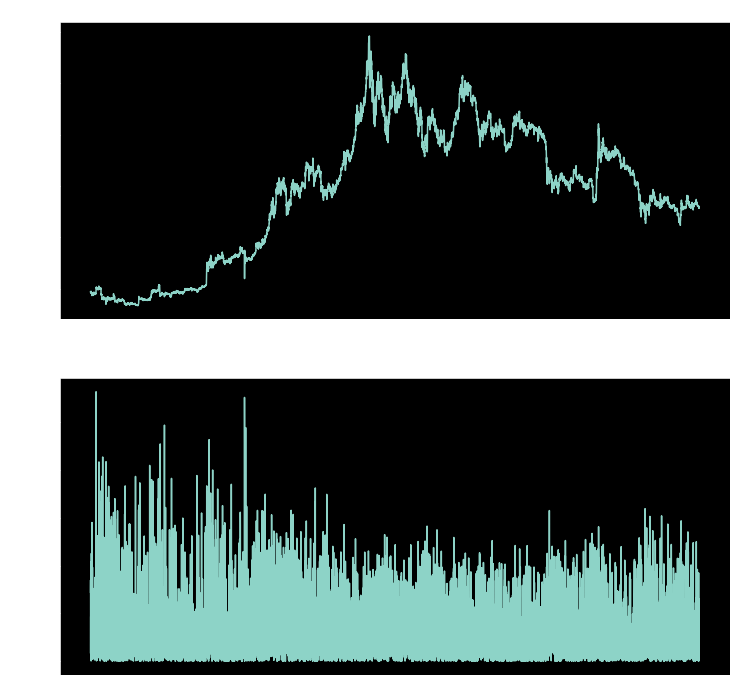

loaded 15101 rows of data from /Users/eric/Projects/cryptonomicon/notebooks/../data/xtbusd_1h_2019_clean.csv


In [61]:
# testing the environment
env = CryptoCandles(FILES, 10)

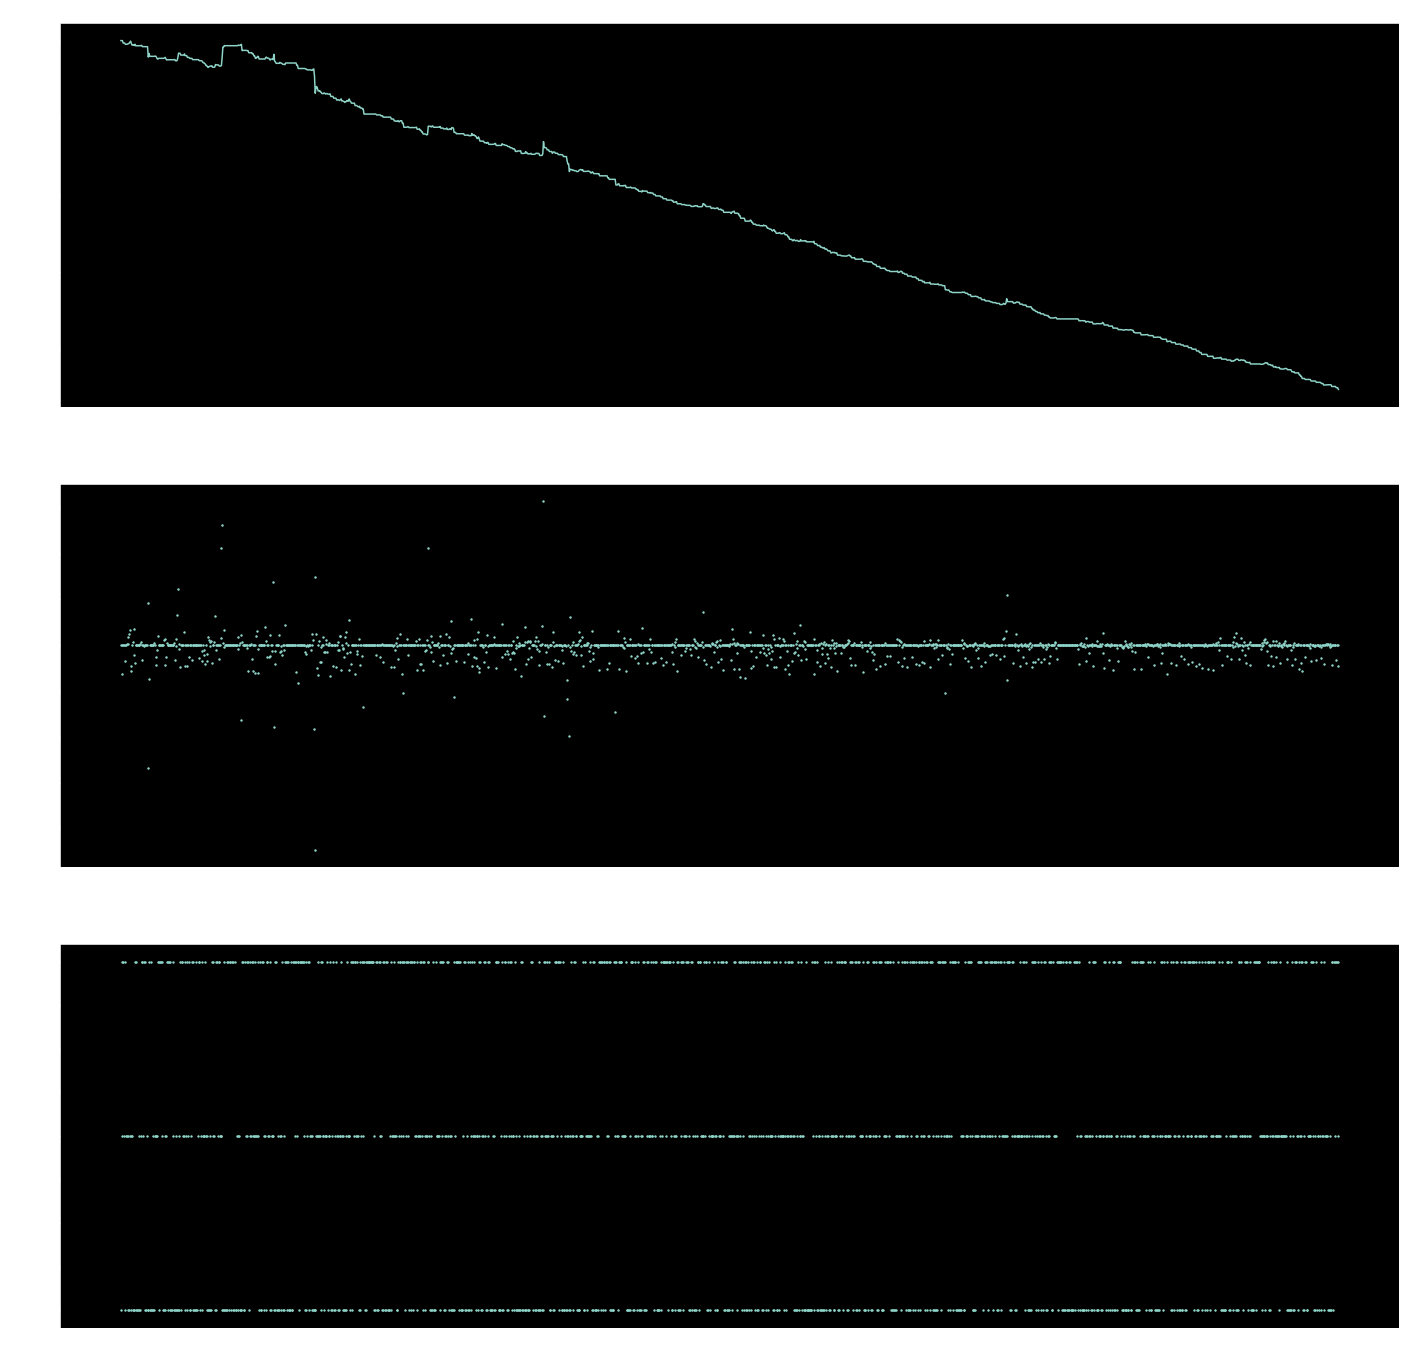

array([0.05918757, 0.05395415, 0.05967897, 0.05362655, 0.05645637,
       0.05436093, 0.05024981, 0.05483211, 0.05024981, 0.05786485,
       0.05372842, 0.04959198, 0.05993307, 0.05372842, 0.04752377,
       0.64059228, 0.57487881, 0.26872736, 0.27843481, 0.15376753,
       0.13799404, 0.25650382, 0.50908971, 0.50761294, 0.51086372,
       0.50761294, 0.53208196, 0.05702541, 0.05918757, 0.05968717,
       0.05656676, 0.05800217, 0.05470491, 0.05052106, 0.05516954,
       0.05051552, 0.05837964, 0.05402275, 0.04966586, 0.06055808,
       0.05402275, 0.04748741, 0.56619239, 0.54564404, 0.27118123,
       0.2821157 , 0.14939067, 0.13749695, 0.12531798, 0.50849718,
       0.50799006, 0.51441318, 0.50864518, 0.53393525, 0.05647668,
       0.05702541, 0.05765604, 0.05518265, 0.0563875 , 0.05509461,
       0.05075791, 0.05537064, 0.05074929, 0.05852834, 0.05438516,
       0.05024197, 0.06059993, 0.05438516, 0.04817038, 0.54804379,
       0.53829491, 0.27337781, 0.2842778 , 0.1727654 , 0.14392

In [62]:
while env.terminal is not True:
    # step and buy
    env.step(random.randint(0,2))
    # env.render()


env.reset()

In [63]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [64]:
def init(module, weight_init, bias_init, gain=1):
    """
    :param module: module to initialize
    :param weight_init: initialization scheme
    :param bias_init: bias initialization scheme
    :param gain: gain for weight initialization
    :return: initialized module
    """
    if hasattr(module, 'weight'):
        weight_init(module.weight.data, gain=gain)
        # weight_init(module.weight.data)
    if hasattr(module, 'bias'):
        bias_init(module.bias.data)
    return module

# the model

class LinnearA2C(nn.Module):

    def __init__(self, num_inputs: int, num_actions: int, hidden_size=128):
        super(LinnearA2C, self).__init__()

        # see: https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/blob/master/a2c_ppo_acktr/model.py

        self.hidden_size = hidden_size
        self.num_inputs = num_inputs

        # networks
        init_ = lambda m: init(m, nn.init.orthogonal_, lambda x: nn.init.
                               constant_(x, 0))

        # init_ = lambda m: init(m, nn.init.kaiming_normal, lambda x: nn.init.
        #                        constant_(x, 0))

        # self.state_representation = nn.Sequential(
        #     init_(nn.Linear(num_inputs, hidden_size * 3)), nn.LeakyReLU(),
        #     init_(nn.Linear(hidden_size * 3, hidden_size * 2)), nn.LeakyReLU(),
        #     init_(nn.Linear(hidden_size * 2, hidden_size)), nn.LeakyReLU(),
        # )

        self.actor = nn.Sequential(
            init_(nn.Linear(num_inputs, hidden_size)), nn.Tanh(),
            init_(nn.Linear(hidden_size, hidden_size)), nn.Tanh(),
            # init_(nn.Linear(hidden_size, hidden_size)), nn.ReLU(),
            init_(nn.Linear(hidden_size, num_actions)), nn.Softmax(),
        )

        self.critic = nn.Sequential(
            init_(nn.Linear(num_inputs, hidden_size)), nn.Tanh(),
            init_(nn.Linear(hidden_size, hidden_size)), nn.Tanh(),
            # init_(nn.Linear(hidden_size, hidden_size)), nn.ReLU(),
            init_(nn.Linear(hidden_size, 1))
        )


    def forward(self, inputs):
        x = inputs
        # x = self.state_representation(x)
        return self.actor(x), self.critic(x)

In [65]:
class Memory:
    """ Memory stores result """
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()

    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)

    def __iter__(self):
        for data in self._zip():
            return data

    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data

    def __len__(self):
        return len(self.rewards)


In [66]:
net = LinnearA2C(env.observation_space.shape[0], env.action_space.n, hidden_size=512)
adam_actor = torch.optim.Adam(net.actor.parameters(), lr=LEARNING_RATE)
adam_critic = torch.optim.Adam(net.critic.parameters(), lr=LEARNING_RATE)
memory = Memory()

In [67]:
# train function
def train(mem, q_val):
    values = torch.stack(mem.values)
    q_vals = np.zeros((len(mem), 1))

    # target values are calculated backward
    # it's super important to handle correctly done states,
    # for those cases we want our to target to be equal to the reward only
    for _i, (_, _, _reward, _done) in enumerate(mem.reversed()):
        q_val = _reward + GAMMA * q_val * (1.0-_done)
        q_vals[len(mem)-1 - _i] = q_val # store values from the end to the beginning

    advantage = torch.Tensor(q_vals) - values

    critic_loss = advantage.pow(2).mean()
    adam_critic.zero_grad()
    critic_loss.backward()
    adam_critic.step()

    actor_loss = (-torch.stack(mem.log_probs)*advantage.detach()).mean()
    adam_actor.zero_grad()
    actor_loss.backward()
    adam_actor.step()

In [68]:
# helper function to convert numpy arrays to tensors
def t(x): return torch.from_numpy(x).float()

/Users/eric/miniconda3/envs/cryptonomicon/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


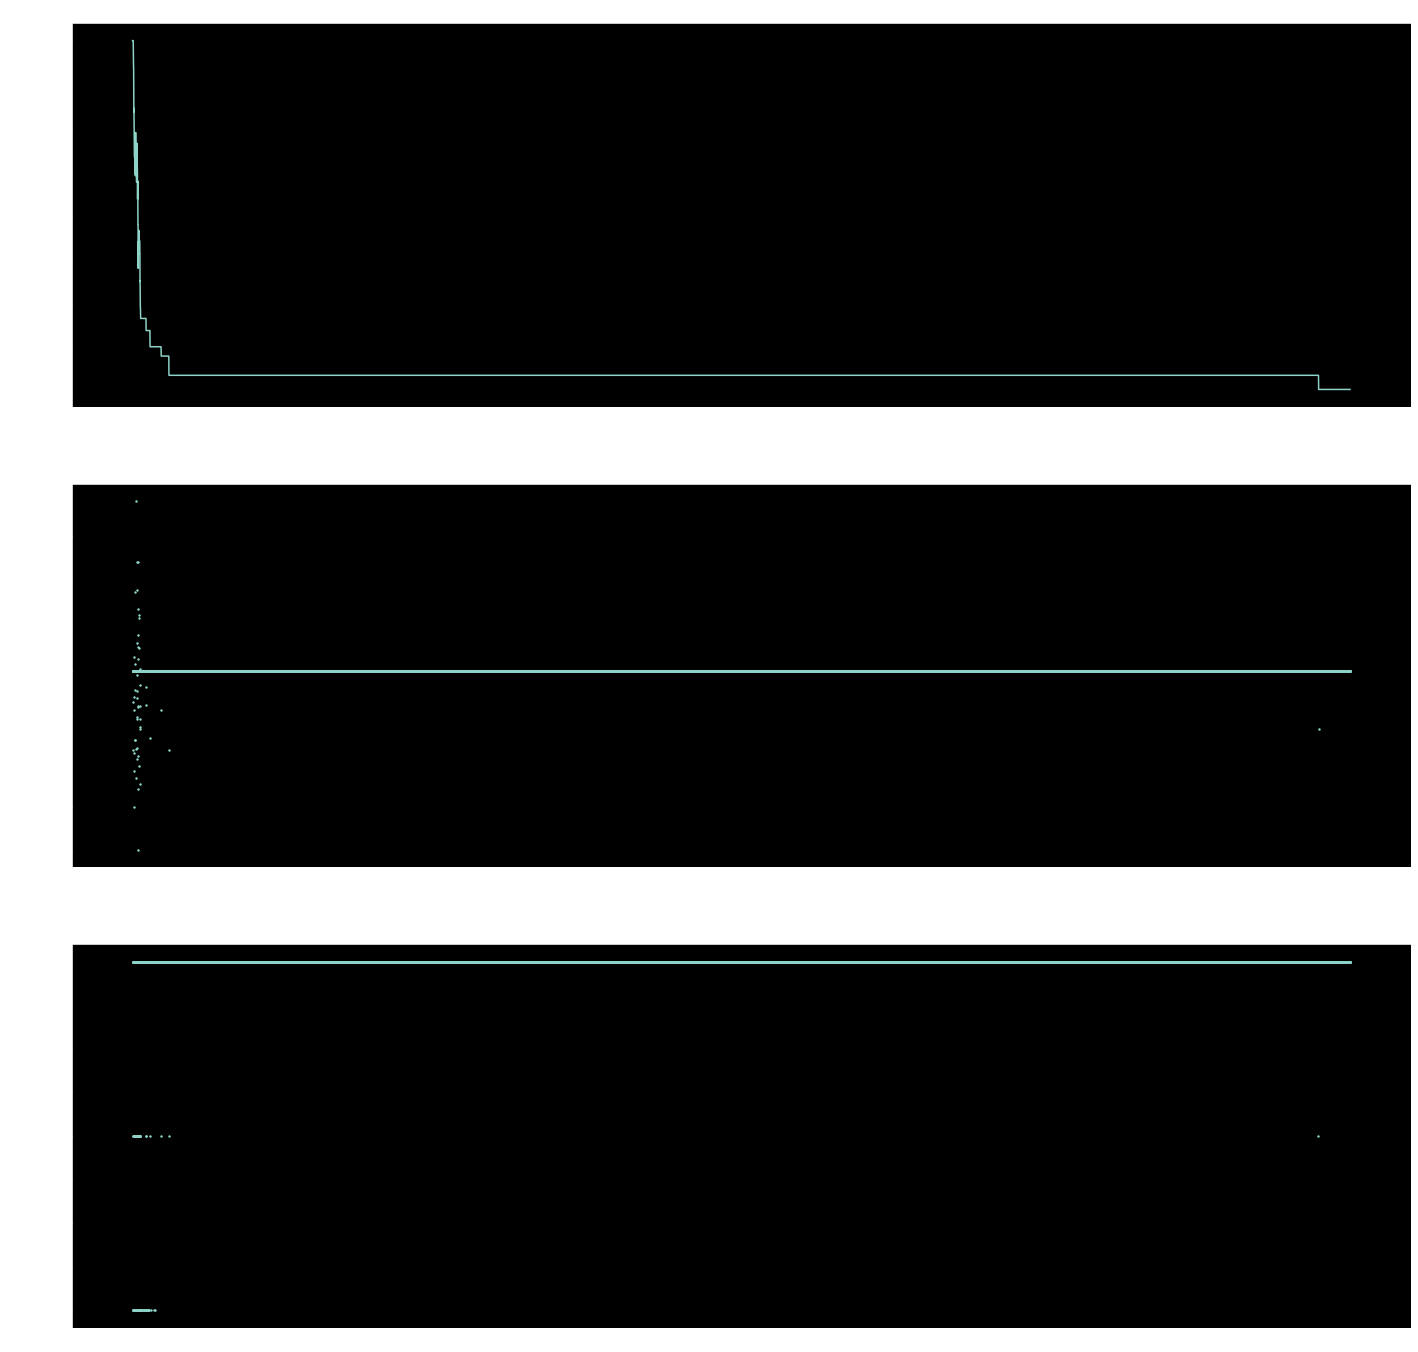

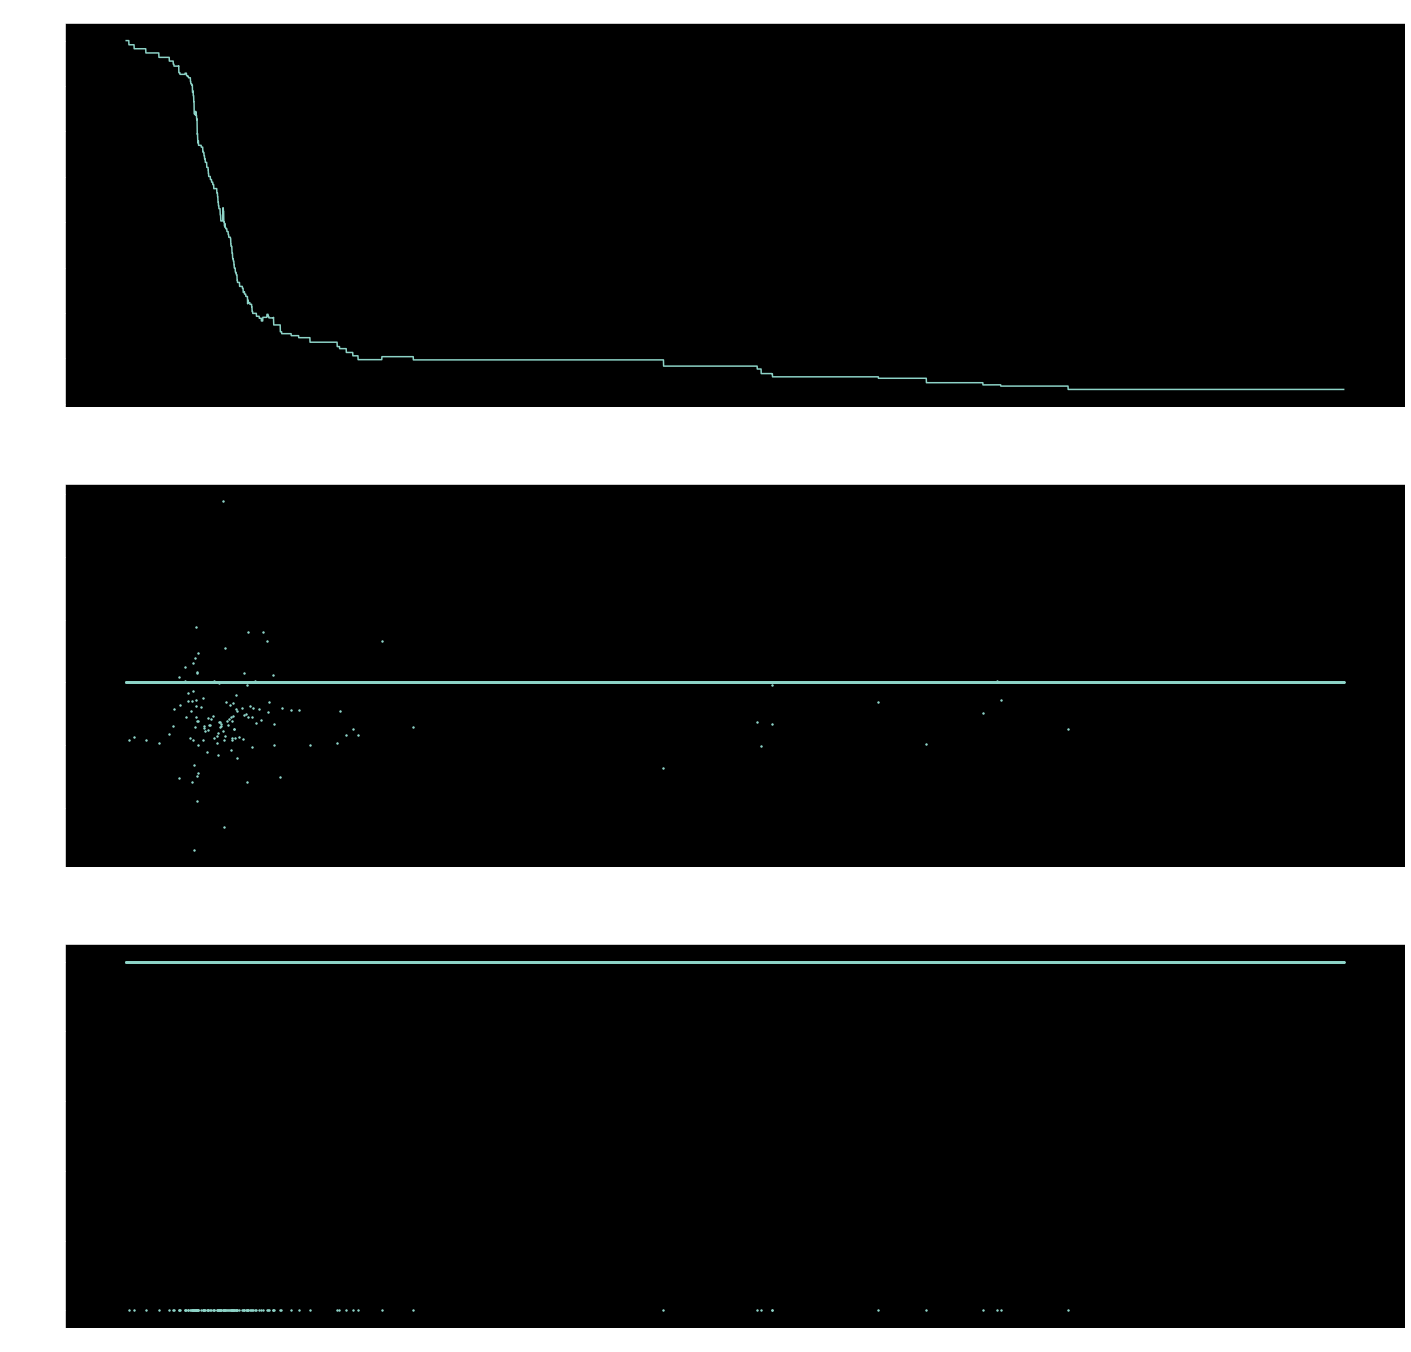

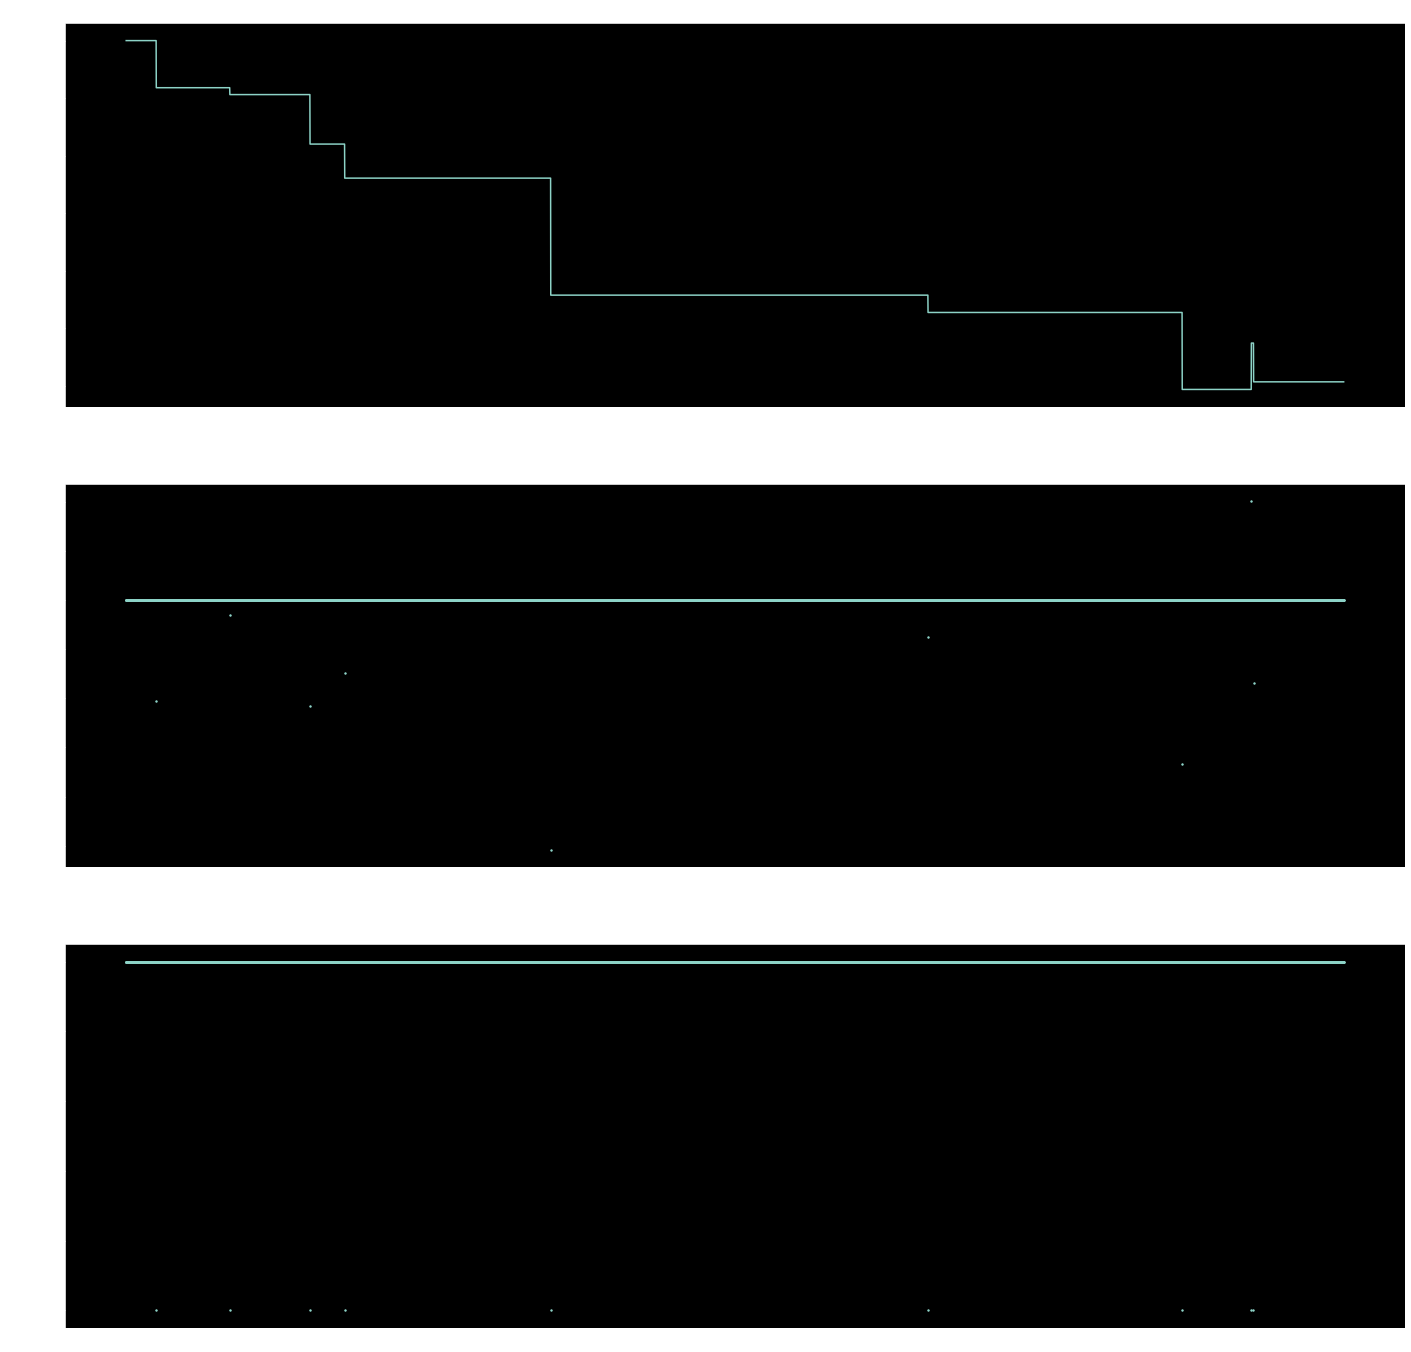

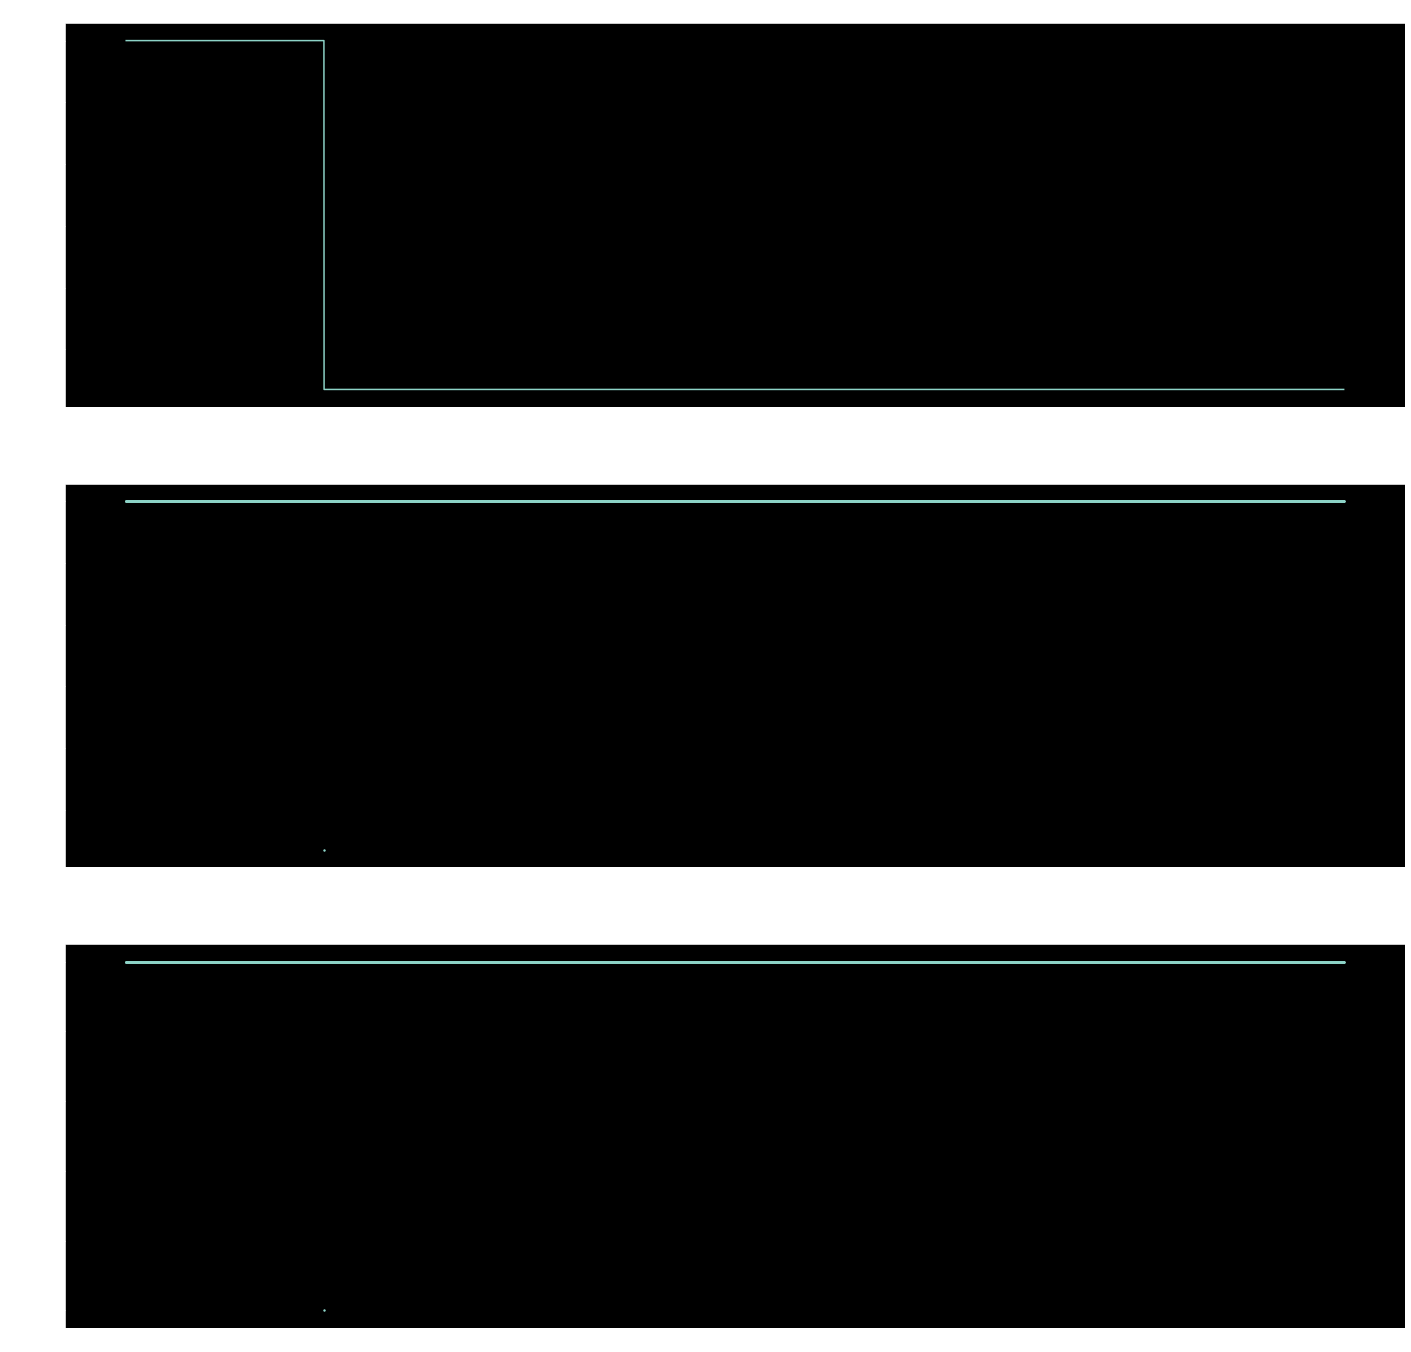

KeyboardInterrupt: 

In [69]:
episode_rewards = []

for i in range(500):
    done = False
    total_reward = 0
    state = env.reset()
    steps = 0

    while not done:
        probs, critic_v = net(t(state))
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()

        next_state, reward, done, _ = env.step(int(action.detach().int()))

        total_reward += reward
        steps += 1
        memory.add(dist.log_prob(action), critic_v, reward, done)

        state = next_state

        # train if done or num steps > max_steps
        if done or (steps % MAX_STEPS == 0):
            last_q_val = critic_v.detach().data.numpy()
            train(memory, last_q_val)
            memory.clear()

    episode_rewards.append(total_reward)

In [ ]:
plt.scatter(np.arange(len(episode_rewards)), episode_rewards, s=2)
plt.title("Total reward per episode (episodic)")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()